In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import nltk
import transformers
from nltk.corpus import stopwords
sw_nltk = stopwords.words('english')
from gensim.models import Word2Vec, word2vec
from transformers import BertTokenizer, AutoTokenizer, BertModel, BertConfig, AutoModel, AdamW
from PIL import Image
import natsort
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.colors as colors
from matplotlib.collections import PatchCollection
import transformers
import os
import pandas as pd
import natsort
import numpy as np
from PIL import Image
import requests
import torch
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
import clip

import torch
from transformers import AutoTokenizer, DistilBertModel
import time
import random
import tensorflow as tf
import transformers
import os
import pandas as pd
import natsort
import numpy as np
from PIL import Image
import time
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.losses import mse
from keras import backend as K
from tensorflow.keras.layers import Dropout
TF_ENABLE_ONEDNN_OPTS=0

2023-07-15 02:33:26.251001: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## BASIC UTIL FUNCTION

In [2]:
def export_classification_report(report, mod, exec_time):
    lines = report.split('\n')
    data = lines[2:4] + lines[5:9]
    data = [line.split() for line in data]
    

    acc = float(data[2][1])
    m_prec = float(data[3][2])
    m_recall = float(data[3][3])
    m_f1 = float(data[3][4])
    w_prec = float(data[4][2])
    w_recall = float(data[4][3])
    w_f1 = float(data[4][4])
    
    df = pd.DataFrame({
        'Model': [mod],
        'Accuracy': [acc],
        'M-Precision': [m_prec],
        'M-Recall': [m_recall],
        'M-F1-Score': [m_f1],
        'W-Precision': [w_prec],
        'W-Recall': [w_recall],
        'W-F1-Score': [w_f1],
        'Runtime': [exec_time]
    })
    
    return df

def apply_text_perturbation(text):
    words = text.split()  # Split the text into words
    perturbed_words = []
    for word in words:
        # Apply perturbation to each word
        if random.random() < 0.2:  # 20% chance of perturbing a word
            perturbed_word = word + "_perturbed"
        else:
            perturbed_word = word
        perturbed_words.append(perturbed_word)
    perturbed_text = " ".join(perturbed_words)  # Join the perturbed words back into a text
    return perturbed_text

## DATA PREPARATION

In [3]:
# Load the data


#  DistilBERT Embeddings (Text Only); (Train and Test Data Embeddings)

train2 = pd.read_csv('./training1.csv', delimiter='\t')

IDs = []  #set1
images = []
directory = 'TRAINING'   # directory where we have images 
filenames = natsort.natsorted(os.listdir(directory))  

# get the ids from the images, where images are having three channels; omit images if channels != 3
for i, filename in enumerate(filenames):
#     print(i, filename)
    if filename.endswith(".jpg"):
#         ID = int(filename[:-4])
        ID = filename
        pathname = os.path.join(directory, filename)
        im = Image.open(pathname)
        im = im.resize((224, 224))  # Resize the image to (224, 224)
        imnp = np.array(im)
        if len(imnp.shape) != 3:
#             print("This is 1 channel, so we omit it", imnp.shape, filename)
            continue
        IDs.append(ID)
        images.append(imnp)

def get_common_strings(list1, list2):
    return list(set(list1) & set(list2))

# Example usage
list1 = IDs
list2 = list(train2.file_name)  #from the text file where we have text description 
common_strings = get_common_strings(list1, list2)
print('len of common strings', len(common_strings))

sorted_ids = natsort.natsorted(common_strings)

# print(sorted_ids)

# Sort the dataframe with natural ordering of the IDs
train2['prefix_file_name'] = train2['file_name'].str.extract('(\d+)').astype(int)
# Assuming 'df' is your DataFrame
sorted_train_df = train2.sort_values(by='prefix_file_name', ascending=True)
sorted_train_df

# Assuming 'df' is your DataFrame and 'common_strings' is the list of strings
# Get the common string values in the column 
filtered_df = sorted_train_df[sorted_train_df['file_name'].isin(sorted_ids)].reset_index(drop=True)

# Print the filtered DataFrame
print('filtered_df shape', filtered_df.shape)

train3 = filtered_df.copy()
# print(train3.shape)

trainx = train3.rename(columns={'Text Transcription': 'text'})
# display(trainx)



### LOAD TEST DATA

test1 = pd.read_csv('Test.csv', delimiter='\t')
test_labels = pd.read_csv('test_labels.txt', 
                          delimiter='\t',
                         header=None)

test_labels.columns = ['file_name', 
                      "misogynous",
                       "shaming",
                       "stereotype",
                       "objectification",
                       "violence"]

merged_test = pd.merge(test1, test_labels, on='file_name', how='inner')


# Sort the dataframe with natural ordering of the IDs
merged_test['prefix_file_name'] = merged_test['file_name'].str.extract('(\d+)').astype(int)
# Assuming 'df' is your DataFrame
merged_test1 = merged_test.sort_values(by='prefix_file_name', ascending=True)
merged_test1


# # train = train.rename(columns={'Text Transcription': 'text'})
test2 = merged_test1.rename(columns={'Text Transcription': 'text'})
# test2



# ######################################################
train = trainx[['file_name', 'text', 'misogynous']]
train = train.rename(columns = {'misogynous':'label'})

test = test2[['file_name', 'text', 'misogynous']]
test = test.rename(columns = {'misogynous':'label'})

train['label'] = train['label'].map({0: 'non_misogyn', 1: 'misogyn'})
test['label'] = test['label'].map({0: 'non_misogyn', 1: 'misogyn'})
display(train)
display(test)


len of common strings 9986
filtered_df shape (9986, 8)


,file_name,text,label
0,1.jpg,Milk Milk.zip,non_misogyn
1,2.jpg,-What are you doing? -you told me to satanize ...,non_misogyn
2,3.jpg,imgflip.com ME 1254 NEW BUGS AFTER CHANGES BUG...,non_misogyn
3,4.jpg,Bedroom Kitchen Bathroom Bron memes storage,non_misogyn
4,5.jpg,WAKEUP EARLY FREELANCERS,non_misogyn
...,...,...,...
9981,15002.jpg,WAITING FOR THE END OF THE COVID imgflip.com,non_misogyn
9982,15003.jpg,SMART WOMEN ARE AROUND imgflip.com,non_misogyn
9983,15004.jpg,GOOD GIRLS ARE BEHIND THE CORNER imgflip.com,non_misogyn
9984,15005.jpg,COOKING FOR MY WIFE imgflip.com,non_misogyn


,file_name,text,label
436,15001.jpg,G HIS. UNDYING FIDELITY Steve is hot and perfe...,non_misogyn
854,15002.jpg,How limagined myself as a Teacher...... How I ...,non_misogyn
743,15004.jpg,WHERE WILL YOU BE WHEN DIARRHEA STRIKE memecen...,non_misogyn
44,15005.jpg,A MAN WITH DREAMS... NEEDS A WOMAN WITH VISION,non_misogyn
873,15006.jpg,THIS IS HOW YOUR GIRLFRIEND SEES YOUR FEMALE F...,non_misogyn
...,...,...,...
871,17078.jpg,There are multiple reasons to lower your car T...,non_misogyn
683,17079.jpg,MICHELLE OBAMA IS A MAN IGUARANTEE IT makeamem...,misogyn
406,17080.jpg,Looks like the airbags deployed 1234498,non_misogyn
733,17081.jpg,Half woman half horse,non_misogyn


## ALL THREE METHODS RUN FOR FEATURE EXTRACTION

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


train embeddings shape: (9986, 64)
test embeddings shape: (1000, 64)
transformer version: 4.15.0
cuda
NVIDIA GeForce RTX 3070 Laptop GPU
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
len of common strings 9986
torch.Size([9986, 512])
Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 512)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          65664       ['encoder_input[0][0]']          
                                                                                                  
 dropout (Dropout)              (None, 128)          0           ['dense[0][0]']                  
                                                        

2023-07-15 02:37:11.542947: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-15 02:37:11.566050: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-15 02:37:11.566179: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-15 02:37:11.566486: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

Epoch 1/10
108/313 [=========>....................] - ETA: 0s - loss: 94.8670 - kl_loss: 1.0675 - mse_loss: 93.7996  

2023-07-15 02:37:12.316892: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


313/313 [==============================] - 1s 1ms/step - loss: 83.0525 - kl_loss: 0.6603 - mse_loss: 82.3922
Epoch 2/10
313/313 [==============================] - 0s 1ms/step - loss: 74.5132 - kl_loss: 0.5421 - mse_loss: 73.9711
Epoch 3/10
313/313 [==============================] - 0s 1ms/step - loss: 73.1406 - kl_loss: 0.6470 - mse_loss: 72.4937
Epoch 4/10
313/313 [==============================] - 0s 1ms/step - loss: 72.2339 - kl_loss: 0.7348 - mse_loss: 71.4991
Epoch 5/10
313/313 [==============================] - 0s 2ms/step - loss: 71.5947 - kl_loss: 0.8093 - mse_loss: 70.7855
Epoch 6/10
313/313 [==============================] - 0s 1ms/step - loss: 71.1830 - kl_loss: 0.8450 - mse_loss: 70.3378
Epoch 7/10
313/313 [==============================] - 0s 1ms/step - loss: 70.6670 - kl_loss: 0.9000 - mse_loss: 69.7670
Epoch 8/10
313/313 [==============================] - 0s 1ms/step - loss: 70.2662 - kl_loss: 0.9371 - mse_loss: 69.3291
Epoch 9/10
313/313 [==============================]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fusion Embeddings Train (9986, 192)
Fusion Embeddings Test (1000, 192)


/home/nitesh/env/dev38/python38/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[0]	validation_0-error:0.18891	validation_0-logloss:0.68446	validation_1-error:0.26076	validation_1-logloss:0.68606
[1]	validation_0-error:0.18828	validation_0-logloss:0.67611	validation_1-error:0.25776	validation_1-logloss:0.67924
[2]	validation_0-error:0.18866	validation_0-logloss:0.66812	validation_1-error:0.25375	validation_1-logloss:0.67272
[3]	validation_0-error:0.18866	validation_0-logloss:0.66040	validation_1-error:0.25025	validation_1-logloss:0.66643
[4]	validation_0-error:0.18440	validation_0-logloss:0.65296	validation_1-error:0.24875	validation_1-logloss:0.66035
[5]	validation_0-error:0.17877	validation_0-logloss:0.64581	validation_1-error:0.24424	validation_1-logloss:0.65442
[6]	validation_0-error:0.17777	validation_0-logloss:0.63893	validation_1-error:0.24424	validation_1-logloss:0.64877
[7]	validation_0-error:0.17364	validation_0-logloss:0.63214	validation_1-error:0.24274	validation_1-logloss:0.64328
[8]	validation_0-error:0.17113	validation_0-logloss:0.62562	validation_1

[71]	validation_0-error:0.12569	validation_0-logloss:0.40187	validation_1-error:0.21171	validation_1-logloss:0.47858
[72]	validation_0-error:0.12519	validation_0-logloss:0.39981	validation_1-error:0.21021	validation_1-logloss:0.47733
[73]	validation_0-error:0.12531	validation_0-logloss:0.39796	validation_1-error:0.21171	validation_1-logloss:0.47612
[74]	validation_0-error:0.12481	validation_0-logloss:0.39593	validation_1-error:0.21171	validation_1-logloss:0.47495
[75]	validation_0-error:0.12506	validation_0-logloss:0.39404	validation_1-error:0.21071	validation_1-logloss:0.47371
[76]	validation_0-error:0.12419	validation_0-logloss:0.39231	validation_1-error:0.21071	validation_1-logloss:0.47275
[77]	validation_0-error:0.12356	validation_0-logloss:0.39024	validation_1-error:0.21121	validation_1-logloss:0.47143
[78]	validation_0-error:0.12256	validation_0-logloss:0.38853	validation_1-error:0.21121	validation_1-logloss:0.47051
[79]	validation_0-error:0.12268	validation_0-logloss:0.38658	val

[141]	validation_0-error:0.09026	validation_0-logloss:0.30114	validation_1-error:0.19369	validation_1-logloss:0.43038
[142]	validation_0-error:0.09026	validation_0-logloss:0.30003	validation_1-error:0.19369	validation_1-logloss:0.42997
[143]	validation_0-error:0.08989	validation_0-logloss:0.29898	validation_1-error:0.19470	validation_1-logloss:0.42940
[144]	validation_0-error:0.08901	validation_0-logloss:0.29789	validation_1-error:0.19419	validation_1-logloss:0.42901
[145]	validation_0-error:0.08888	validation_0-logloss:0.29709	validation_1-error:0.19369	validation_1-logloss:0.42858
[146]	validation_0-error:0.08801	validation_0-logloss:0.29590	validation_1-error:0.19419	validation_1-logloss:0.42838
[147]	validation_0-error:0.08776	validation_0-logloss:0.29484	validation_1-error:0.19570	validation_1-logloss:0.42805
[148]	validation_0-error:0.08751	validation_0-logloss:0.29371	validation_1-error:0.19470	validation_1-logloss:0.42757
[149]	validation_0-error:0.08600	validation_0-logloss:0.

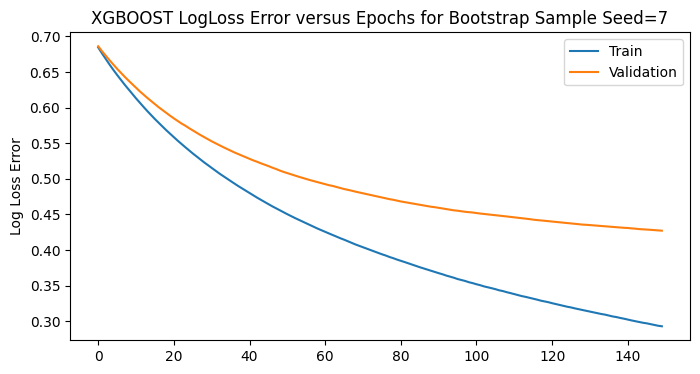

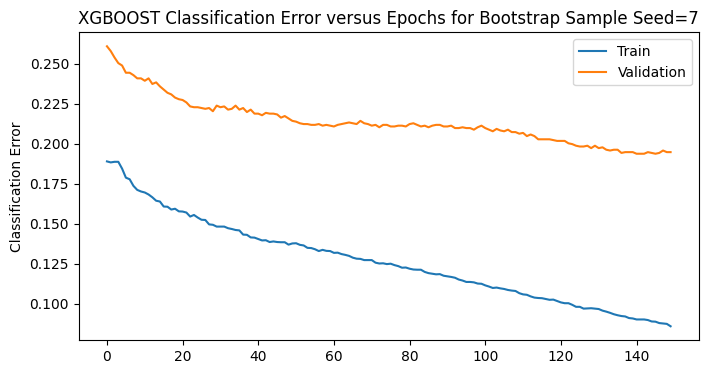

/tmp/ipykernel_53637/3764144227.py:541: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xgboost_clsfn_errrep = xgboost_clsfn_errrep.append(row_data, ignore_index=True)


              precision    recall  f1-score   support

           0       0.89      0.51      0.65       500
           1       0.65      0.93      0.77       500

    accuracy                           0.72      1000
   macro avg       0.77      0.72      0.71      1000
weighted avg       0.77      0.72      0.71      1000

Execution time: 259.5059428215027 seconds


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


train embeddings shape: (9986, 64)
test embeddings shape: (1000, 64)
transformer version: 4.15.0
cuda
NVIDIA GeForce RTX 3070 Laptop GPU
Memory Usage:
Allocated: 0.0 GB
Cached:    0.4 GB
len of common strings 9986
torch.Size([9986, 512])
Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 512)]        0           []                               
                                                                                                  
 dense_5 (Dense)                (None, 128)          65664       ['encoder_input[0][0]']          
                                                                                                  
 dropout_2 (Dropout)            (None, 128)          0           ['dense_5[0][0]']                
                                                        

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fusion Embeddings Train (9986, 192)
Fusion Embeddings Test (1000, 192)
[0]	validation_0-error:0.20030	validation_0-logloss:0.68494	validation_1-error:0.27177	validation_1-logloss:0.68669
[1]	validation_0-error:0.18928	validation_0-logloss:0.67707	validation_1-error:0.26076	validation_1-logloss:0.68012
[2]	validation_0-error:0.19016	validation_0-logloss:0.66942	validation_1-error:0.25626	validation_1-logloss:0.67404
[3]	validation_0-error:0.18703	validation_0-logloss:0.66208	validation_1-error:0.24825	validation_1-logloss:0.66786
[4]	validation_0-error:0.18152	validation_0-logloss:0.65493	validation_1-error:0.25275	validation_1-logloss:0.66191
[5]	validation_0-error:0.18352	validation_0-logloss:0.64806	validation_1-error:0.24575	validation_1-logloss:0.65647
[6]	validation_0-error:0.18102	validation_0-logloss:0.64136	validation_1-error:0.24424	validation_1-logloss:0.65119
[7]	validation_0-error:0.17927	validation_0-logloss:0.63491	validation_1-error:0.23824	validation_1-logloss:0.64593
[

[70]	validation_0-error:0.11592	validation_0-logloss:0.40957	validation_1-error:0.19520	validation_1-logloss:0.48344
[71]	validation_0-error:0.11580	validation_0-logloss:0.40760	validation_1-error:0.19369	validation_1-logloss:0.48231
[72]	validation_0-error:0.11517	validation_0-logloss:0.40542	validation_1-error:0.19269	validation_1-logloss:0.48104
[73]	validation_0-error:0.11430	validation_0-logloss:0.40354	validation_1-error:0.19419	validation_1-logloss:0.47980
[74]	validation_0-error:0.11380	validation_0-logloss:0.40165	validation_1-error:0.19419	validation_1-logloss:0.47868
[75]	validation_0-error:0.11405	validation_0-logloss:0.39963	validation_1-error:0.19520	validation_1-logloss:0.47766
[76]	validation_0-error:0.11354	validation_0-logloss:0.39797	validation_1-error:0.19169	validation_1-logloss:0.47656
[77]	validation_0-error:0.11229	validation_0-logloss:0.39595	validation_1-error:0.19169	validation_1-logloss:0.47554
[78]	validation_0-error:0.11204	validation_0-logloss:0.39418	val

[140]	validation_0-error:0.08588	validation_0-logloss:0.31027	validation_1-error:0.18619	validation_1-logloss:0.43148
[141]	validation_0-error:0.08588	validation_0-logloss:0.30944	validation_1-error:0.18569	validation_1-logloss:0.43107
[142]	validation_0-error:0.08563	validation_0-logloss:0.30844	validation_1-error:0.18619	validation_1-logloss:0.43072
[143]	validation_0-error:0.08488	validation_0-logloss:0.30733	validation_1-error:0.18518	validation_1-logloss:0.43013
[144]	validation_0-error:0.08438	validation_0-logloss:0.30628	validation_1-error:0.18669	validation_1-logloss:0.42997
[145]	validation_0-error:0.08450	validation_0-logloss:0.30542	validation_1-error:0.18518	validation_1-logloss:0.42964
[146]	validation_0-error:0.08375	validation_0-logloss:0.30426	validation_1-error:0.18569	validation_1-logloss:0.42916
[147]	validation_0-error:0.08262	validation_0-logloss:0.30332	validation_1-error:0.18669	validation_1-logloss:0.42886
[148]	validation_0-error:0.08212	validation_0-logloss:0.

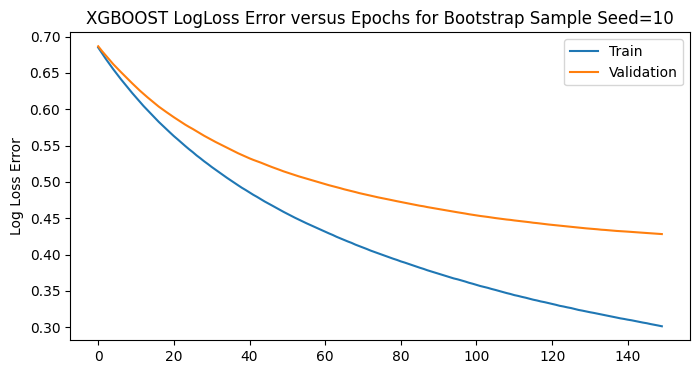

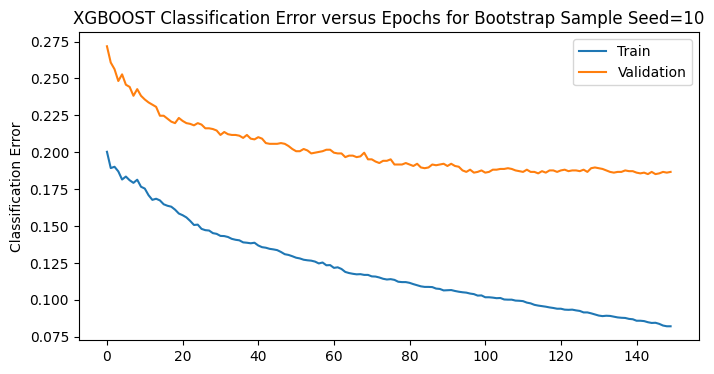

/tmp/ipykernel_53637/3764144227.py:541: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xgboost_clsfn_errrep = xgboost_clsfn_errrep.append(row_data, ignore_index=True)


              precision    recall  f1-score   support

           0       0.86      0.52      0.65       500
           1       0.66      0.92      0.76       500

    accuracy                           0.72      1000
   macro avg       0.76      0.72      0.71      1000
weighted avg       0.76      0.72      0.71      1000

Execution time: 275.1650948524475 seconds


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


train embeddings shape: (9986, 64)
test embeddings shape: (1000, 64)
transformer version: 4.15.0
cuda
NVIDIA GeForce RTX 3070 Laptop GPU
Memory Usage:
Allocated: 0.0 GB
Cached:    0.4 GB
len of common strings 9986
torch.Size([9986, 512])
Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 512)]        0           []                               
                                                                                                  
 dense_10 (Dense)               (None, 128)          65664       ['encoder_input[0][0]']          
                                                                                                  
 dropout_4 (Dropout)            (None, 128)          0           ['dense_10[0][0]']               
                                                        

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fusion Embeddings Train (9986, 192)
Fusion Embeddings Test (1000, 192)
[0]	validation_0-error:0.18052	validation_0-logloss:0.68416	validation_1-error:0.25325	validation_1-logloss:0.68585
[1]	validation_0-error:0.17739	validation_0-logloss:0.67556	validation_1-error:0.24374	validation_1-logloss:0.67868
[2]	validation_0-error:0.16938	validation_0-logloss:0.66719	validation_1-error:0.24074	validation_1-logloss:0.67190
[3]	validation_0-error:0.16387	validation_0-logloss:0.65902	validation_1-error:0.23373	validation_1-logloss:0.66517
[4]	validation_0-error:0.15836	validation_0-logloss:0.65120	validation_1-error:0.23073	validation_1-logloss:0.65900
[5]	validation_0-error:0.15661	validation_0-logloss:0.64362	validation_1-error:0.23023	validation_1-logloss:0.65268
[6]	validation_0-error:0.15586	validation_0-logloss:0.63631	validation_1-error:0.22723	validation_1-logloss:0.64699
[7]	validation_0-error:0.15423	validation_0-logloss:0.62912	validation_1-error:0.21972	validation_1-logloss:0.64123
[

[70]	validation_0-error:0.12068	validation_0-logloss:0.39606	validation_1-error:0.20871	validation_1-logloss:0.47603
[71]	validation_0-error:0.12018	validation_0-logloss:0.39424	validation_1-error:0.20971	validation_1-logloss:0.47487
[72]	validation_0-error:0.11980	validation_0-logloss:0.39244	validation_1-error:0.20921	validation_1-logloss:0.47387
[73]	validation_0-error:0.12018	validation_0-logloss:0.39068	validation_1-error:0.20921	validation_1-logloss:0.47276
[74]	validation_0-error:0.11918	validation_0-logloss:0.38876	validation_1-error:0.20871	validation_1-logloss:0.47166
[75]	validation_0-error:0.11993	validation_0-logloss:0.38687	validation_1-error:0.20921	validation_1-logloss:0.47071
[76]	validation_0-error:0.11905	validation_0-logloss:0.38505	validation_1-error:0.21171	validation_1-logloss:0.46986
[77]	validation_0-error:0.11880	validation_0-logloss:0.38321	validation_1-error:0.21071	validation_1-logloss:0.46876
[78]	validation_0-error:0.11768	validation_0-logloss:0.38134	val

[140]	validation_0-error:0.09214	validation_0-logloss:0.29728	validation_1-error:0.20120	validation_1-logloss:0.42988
[141]	validation_0-error:0.09201	validation_0-logloss:0.29646	validation_1-error:0.20020	validation_1-logloss:0.42972
[142]	validation_0-error:0.09189	validation_0-logloss:0.29545	validation_1-error:0.20020	validation_1-logloss:0.42931
[143]	validation_0-error:0.09114	validation_0-logloss:0.29445	validation_1-error:0.20070	validation_1-logloss:0.42900
[144]	validation_0-error:0.09064	validation_0-logloss:0.29330	validation_1-error:0.20170	validation_1-logloss:0.42876
[145]	validation_0-error:0.09039	validation_0-logloss:0.29249	validation_1-error:0.20220	validation_1-logloss:0.42851
[146]	validation_0-error:0.09026	validation_0-logloss:0.29179	validation_1-error:0.20220	validation_1-logloss:0.42825
[147]	validation_0-error:0.08989	validation_0-logloss:0.29084	validation_1-error:0.20220	validation_1-logloss:0.42792
[148]	validation_0-error:0.09001	validation_0-logloss:0.

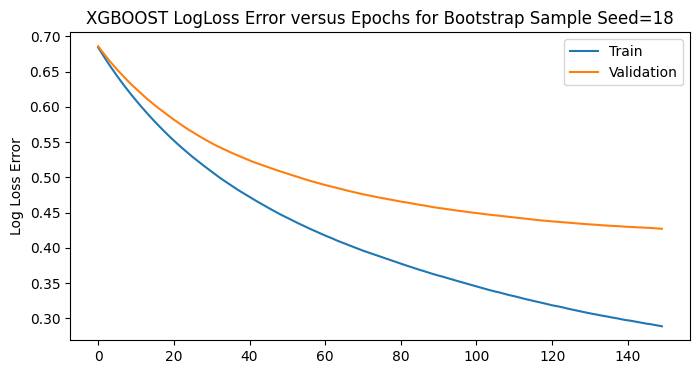

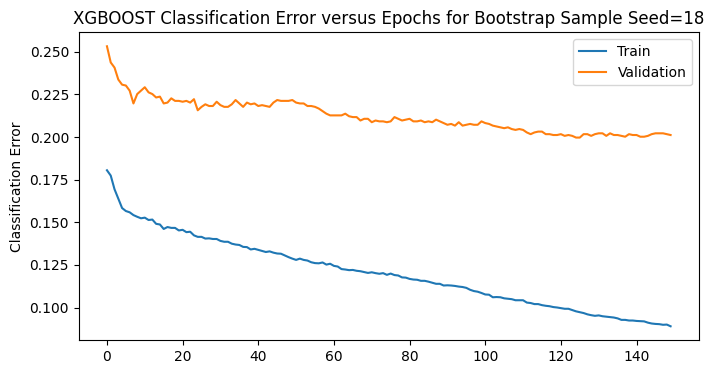

/tmp/ipykernel_53637/3764144227.py:541: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xgboost_clsfn_errrep = xgboost_clsfn_errrep.append(row_data, ignore_index=True)


              precision    recall  f1-score   support

           0       0.89      0.51      0.65       500
           1       0.66      0.93      0.77       500

    accuracy                           0.72      1000
   macro avg       0.77      0.72      0.71      1000
weighted avg       0.77      0.72      0.71      1000

Execution time: 271.32609510421753 seconds


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


train embeddings shape: (9986, 64)
test embeddings shape: (1000, 64)
transformer version: 4.15.0
cuda
NVIDIA GeForce RTX 3070 Laptop GPU
Memory Usage:
Allocated: 0.0 GB
Cached:    0.4 GB
len of common strings 9986
torch.Size([9986, 512])
Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 512)]        0           []                               
                                                                                                  
 dense_15 (Dense)               (None, 128)          65664       ['encoder_input[0][0]']          
                                                                                                  
 dropout_6 (Dropout)            (None, 128)          0           ['dense_15[0][0]']               
                                                        

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fusion Embeddings Train (9986, 192)
Fusion Embeddings Test (1000, 192)
[0]	validation_0-error:0.20118	validation_0-logloss:0.68510	validation_1-error:0.25325	validation_1-logloss:0.68627
[1]	validation_0-error:0.19091	validation_0-logloss:0.67743	validation_1-error:0.23624	validation_1-logloss:0.67989
[2]	validation_0-error:0.18853	validation_0-logloss:0.66992	validation_1-error:0.24024	validation_1-logloss:0.67375
[3]	validation_0-error:0.18315	validation_0-logloss:0.66278	validation_1-error:0.22973	validation_1-logloss:0.66788
[4]	validation_0-error:0.18040	validation_0-logloss:0.65551	validation_1-error:0.22823	validation_1-logloss:0.66200
[5]	validation_0-error:0.18065	validation_0-logloss:0.64870	validation_1-error:0.23123	validation_1-logloss:0.65647
[6]	validation_0-error:0.17589	validation_0-logloss:0.64211	validation_1-error:0.23223	validation_1-logloss:0.65129
[7]	validation_0-error:0.17376	validation_0-logloss:0.63550	validation_1-error:0.23223	validation_1-logloss:0.64598
[

[70]	validation_0-error:0.11843	validation_0-logloss:0.41100	validation_1-error:0.20971	validation_1-logloss:0.48841
[71]	validation_0-error:0.11805	validation_0-logloss:0.40895	validation_1-error:0.20921	validation_1-logloss:0.48742
[72]	validation_0-error:0.11830	validation_0-logloss:0.40692	validation_1-error:0.20671	validation_1-logloss:0.48616
[73]	validation_0-error:0.11805	validation_0-logloss:0.40488	validation_1-error:0.20921	validation_1-logloss:0.48507
[74]	validation_0-error:0.11768	validation_0-logloss:0.40297	validation_1-error:0.21121	validation_1-logloss:0.48391
[75]	validation_0-error:0.11705	validation_0-logloss:0.40094	validation_1-error:0.21221	validation_1-logloss:0.48294
[76]	validation_0-error:0.11680	validation_0-logloss:0.39892	validation_1-error:0.21521	validation_1-logloss:0.48181
[77]	validation_0-error:0.11592	validation_0-logloss:0.39708	validation_1-error:0.21371	validation_1-logloss:0.48067
[78]	validation_0-error:0.11592	validation_0-logloss:0.39549	val

[140]	validation_0-error:0.08801	validation_0-logloss:0.31307	validation_1-error:0.20370	validation_1-logloss:0.43642
[141]	validation_0-error:0.08726	validation_0-logloss:0.31195	validation_1-error:0.20370	validation_1-logloss:0.43590
[142]	validation_0-error:0.08688	validation_0-logloss:0.31099	validation_1-error:0.20370	validation_1-logloss:0.43547
[143]	validation_0-error:0.08738	validation_0-logloss:0.30984	validation_1-error:0.20320	validation_1-logloss:0.43493
[144]	validation_0-error:0.08726	validation_0-logloss:0.30889	validation_1-error:0.20270	validation_1-logloss:0.43461
[145]	validation_0-error:0.08688	validation_0-logloss:0.30798	validation_1-error:0.20370	validation_1-logloss:0.43428
[146]	validation_0-error:0.08650	validation_0-logloss:0.30727	validation_1-error:0.20370	validation_1-logloss:0.43409
[147]	validation_0-error:0.08638	validation_0-logloss:0.30616	validation_1-error:0.20270	validation_1-logloss:0.43363
[148]	validation_0-error:0.08613	validation_0-logloss:0.

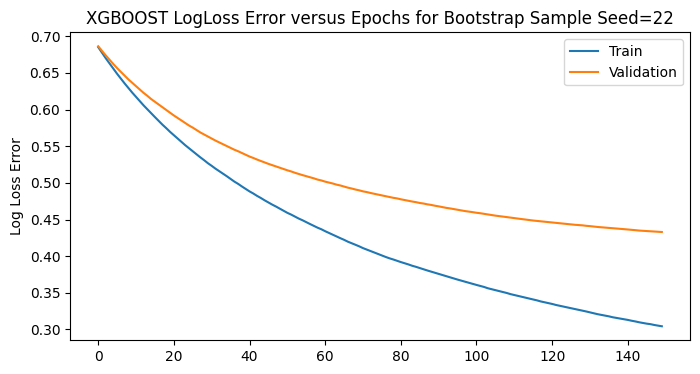

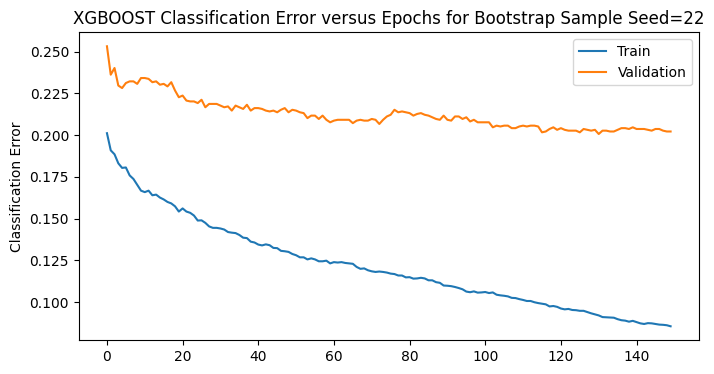

/tmp/ipykernel_53637/3764144227.py:541: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xgboost_clsfn_errrep = xgboost_clsfn_errrep.append(row_data, ignore_index=True)


              precision    recall  f1-score   support

           0       0.88      0.49      0.63       500
           1       0.65      0.93      0.76       500

    accuracy                           0.71      1000
   macro avg       0.76      0.71      0.70      1000
weighted avg       0.76      0.71      0.70      1000

Execution time: 276.99022150039673 seconds


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


train embeddings shape: (9986, 64)
test embeddings shape: (1000, 64)
transformer version: 4.15.0
cuda
NVIDIA GeForce RTX 3070 Laptop GPU
Memory Usage:
Allocated: 0.0 GB
Cached:    0.4 GB
len of common strings 9986
torch.Size([9986, 512])
Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 512)]        0           []                               
                                                                                                  
 dense_20 (Dense)               (None, 128)          65664       ['encoder_input[0][0]']          
                                                                                                  
 dropout_8 (Dropout)            (None, 128)          0           ['dense_20[0][0]']               
                                                        

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fusion Embeddings Train (9986, 192)
Fusion Embeddings Test (1000, 192)
[0]	validation_0-error:0.20593	validation_0-logloss:0.68507	validation_1-error:0.27578	validation_1-logloss:0.68656
[1]	validation_0-error:0.19742	validation_0-logloss:0.67723	validation_1-error:0.26326	validation_1-logloss:0.67997
[2]	validation_0-error:0.19679	validation_0-logloss:0.66962	validation_1-error:0.26226	validation_1-logloss:0.67390
[3]	validation_0-error:0.19429	validation_0-logloss:0.66228	validation_1-error:0.25626	validation_1-logloss:0.66803
[4]	validation_0-error:0.19066	validation_0-logloss:0.65508	validation_1-error:0.25425	validation_1-logloss:0.66227
[5]	validation_0-error:0.18891	validation_0-logloss:0.64817	validation_1-error:0.24975	validation_1-logloss:0.65671
[6]	validation_0-error:0.18465	validation_0-logloss:0.64142	validation_1-error:0.24775	validation_1-logloss:0.65128
[7]	validation_0-error:0.17777	validation_0-logloss:0.63485	validation_1-error:0.24775	validation_1-logloss:0.64616
[

[70]	validation_0-error:0.11492	validation_0-logloss:0.40557	validation_1-error:0.20470	validation_1-logloss:0.48051
[71]	validation_0-error:0.11380	validation_0-logloss:0.40331	validation_1-error:0.20470	validation_1-logloss:0.47926
[72]	validation_0-error:0.11317	validation_0-logloss:0.40137	validation_1-error:0.20520	validation_1-logloss:0.47799
[73]	validation_0-error:0.11267	validation_0-logloss:0.39933	validation_1-error:0.20520	validation_1-logloss:0.47681
[74]	validation_0-error:0.11167	validation_0-logloss:0.39730	validation_1-error:0.20520	validation_1-logloss:0.47556
[75]	validation_0-error:0.11129	validation_0-logloss:0.39557	validation_1-error:0.20571	validation_1-logloss:0.47448
[76]	validation_0-error:0.11092	validation_0-logloss:0.39365	validation_1-error:0.20571	validation_1-logloss:0.47336
[77]	validation_0-error:0.10991	validation_0-logloss:0.39165	validation_1-error:0.20520	validation_1-logloss:0.47211
[78]	validation_0-error:0.10979	validation_0-logloss:0.38964	val

[140]	validation_0-error:0.08338	validation_0-logloss:0.30538	validation_1-error:0.19720	validation_1-logloss:0.42793
[141]	validation_0-error:0.08287	validation_0-logloss:0.30433	validation_1-error:0.19620	validation_1-logloss:0.42742
[142]	validation_0-error:0.08275	validation_0-logloss:0.30332	validation_1-error:0.19620	validation_1-logloss:0.42689
[143]	validation_0-error:0.08237	validation_0-logloss:0.30257	validation_1-error:0.19670	validation_1-logloss:0.42663
[144]	validation_0-error:0.08225	validation_0-logloss:0.30171	validation_1-error:0.19570	validation_1-logloss:0.42618
[145]	validation_0-error:0.08212	validation_0-logloss:0.30060	validation_1-error:0.19670	validation_1-logloss:0.42587
[146]	validation_0-error:0.08150	validation_0-logloss:0.29956	validation_1-error:0.19720	validation_1-logloss:0.42542
[147]	validation_0-error:0.08162	validation_0-logloss:0.29876	validation_1-error:0.19820	validation_1-logloss:0.42510
[148]	validation_0-error:0.08075	validation_0-logloss:0.

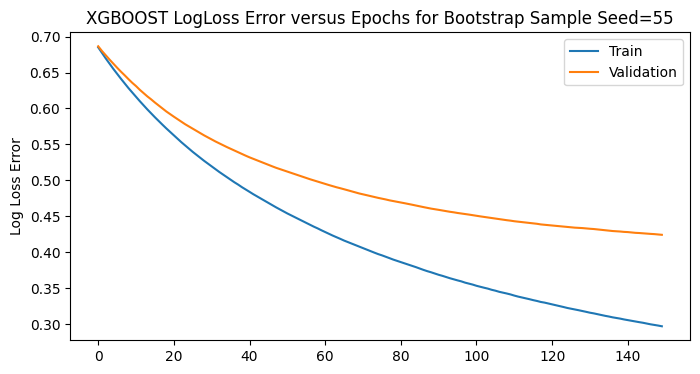

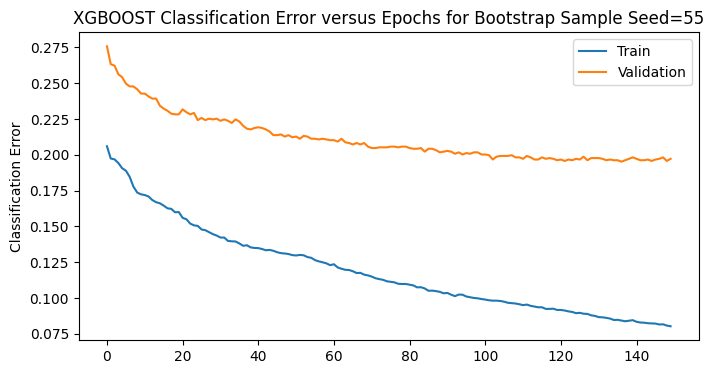

/tmp/ipykernel_53637/3764144227.py:541: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xgboost_clsfn_errrep = xgboost_clsfn_errrep.append(row_data, ignore_index=True)


              precision    recall  f1-score   support

           0       0.86      0.50      0.63       500
           1       0.65      0.92      0.76       500

    accuracy                           0.71      1000
   macro avg       0.76      0.71      0.70      1000
weighted avg       0.76      0.71      0.70      1000

Execution time: 281.24896335601807 seconds


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


train embeddings shape: (9986, 64)
test embeddings shape: (1000, 64)
transformer version: 4.15.0
cuda
NVIDIA GeForce RTX 3070 Laptop GPU
Memory Usage:
Allocated: 0.0 GB
Cached:    0.4 GB
len of common strings 9986
torch.Size([9986, 512])
Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 512)]        0           []                               
                                                                                                  
 dense_25 (Dense)               (None, 128)          65664       ['encoder_input[0][0]']          
                                                                                                  
 dropout_10 (Dropout)           (None, 128)          0           ['dense_25[0][0]']               
                                                        

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fusion Embeddings Train (9986, 192)
Fusion Embeddings Test (1000, 192)
[0]	validation_0-error:0.19216	validation_0-logloss:0.68403	validation_1-error:0.24174	validation_1-logloss:0.68545
[1]	validation_0-error:0.18966	validation_0-logloss:0.67530	validation_1-error:0.23674	validation_1-logloss:0.67807
[2]	validation_0-error:0.17989	validation_0-logloss:0.66680	validation_1-error:0.22723	validation_1-logloss:0.67072
[3]	validation_0-error:0.18152	validation_0-logloss:0.65854	validation_1-error:0.22773	validation_1-logloss:0.66367
[4]	validation_0-error:0.17251	validation_0-logloss:0.65058	validation_1-error:0.21972	validation_1-logloss:0.65713
[5]	validation_0-error:0.17251	validation_0-logloss:0.64293	validation_1-error:0.21772	validation_1-logloss:0.65077
[6]	validation_0-error:0.16562	validation_0-logloss:0.63535	validation_1-error:0.21271	validation_1-logloss:0.64490
[7]	validation_0-error:0.16274	validation_0-logloss:0.62807	validation_1-error:0.21772	validation_1-logloss:0.63926
[

[70]	validation_0-error:0.12218	validation_0-logloss:0.39301	validation_1-error:0.19620	validation_1-logloss:0.46969
[71]	validation_0-error:0.12143	validation_0-logloss:0.39104	validation_1-error:0.19670	validation_1-logloss:0.46854
[72]	validation_0-error:0.12131	validation_0-logloss:0.38897	validation_1-error:0.19620	validation_1-logloss:0.46751
[73]	validation_0-error:0.12118	validation_0-logloss:0.38690	validation_1-error:0.19520	validation_1-logloss:0.46647
[74]	validation_0-error:0.12081	validation_0-logloss:0.38496	validation_1-error:0.19820	validation_1-logloss:0.46546
[75]	validation_0-error:0.12018	validation_0-logloss:0.38305	validation_1-error:0.19570	validation_1-logloss:0.46452
[76]	validation_0-error:0.11993	validation_0-logloss:0.38117	validation_1-error:0.19620	validation_1-logloss:0.46355
[77]	validation_0-error:0.11943	validation_0-logloss:0.37928	validation_1-error:0.19720	validation_1-logloss:0.46244
[78]	validation_0-error:0.11893	validation_0-logloss:0.37739	val

[140]	validation_0-error:0.09089	validation_0-logloss:0.29496	validation_1-error:0.19369	validation_1-logloss:0.42673
[141]	validation_0-error:0.09051	validation_0-logloss:0.29402	validation_1-error:0.19369	validation_1-logloss:0.42644
[142]	validation_0-error:0.09001	validation_0-logloss:0.29299	validation_1-error:0.19369	validation_1-logloss:0.42615
[143]	validation_0-error:0.08901	validation_0-logloss:0.29196	validation_1-error:0.19319	validation_1-logloss:0.42560
[144]	validation_0-error:0.08876	validation_0-logloss:0.29087	validation_1-error:0.19119	validation_1-logloss:0.42523
[145]	validation_0-error:0.08876	validation_0-logloss:0.28988	validation_1-error:0.19169	validation_1-logloss:0.42487
[146]	validation_0-error:0.08813	validation_0-logloss:0.28903	validation_1-error:0.19269	validation_1-logloss:0.42453
[147]	validation_0-error:0.08763	validation_0-logloss:0.28801	validation_1-error:0.19169	validation_1-logloss:0.42400
[148]	validation_0-error:0.08701	validation_0-logloss:0.

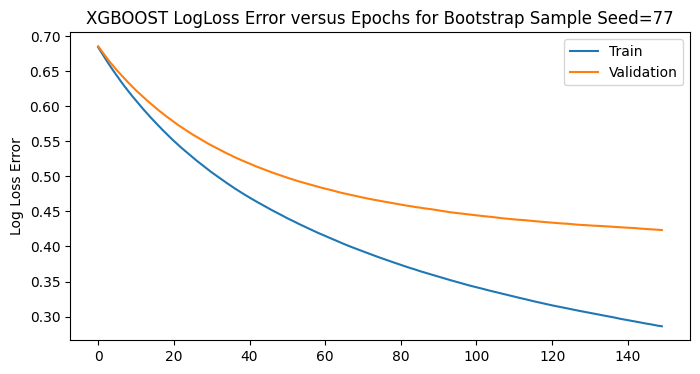

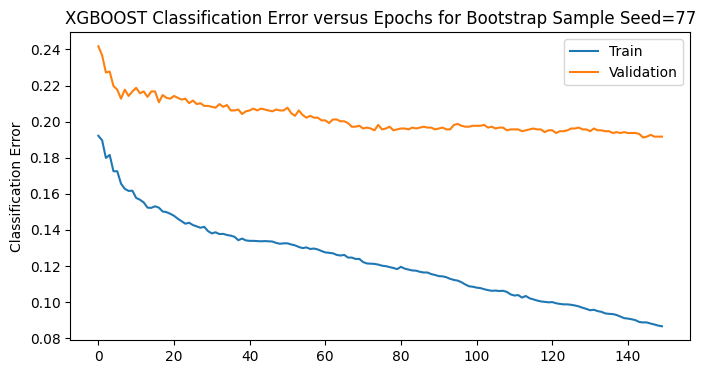

              precision    recall  f1-score   support

           0       0.86      0.50      0.63       500
           1       0.65      0.92      0.76       500

    accuracy                           0.71      1000
   macro avg       0.75      0.71      0.70      1000
weighted avg       0.75      0.71      0.70      1000

Execution time: 290.00408267974854 seconds


/tmp/ipykernel_53637/3764144227.py:541: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xgboost_clsfn_errrep = xgboost_clsfn_errrep.append(row_data, ignore_index=True)


In [4]:
### TRAINING

df_BLPCLPXGB = pd.DataFrame(columns=['Model', 'Accuracy', 
                       'M-Precision', 'M-Recall', 
                       'M-F1-Score', 'W-Precision',
                       'W-Recall', 'W-F1-Score', 'Runtime'])


mse_val1 = []
KL_LOSS1 = []

# Store results in DataFrame
xgboost_clsfn_errrep  = pd.DataFrame(columns=["Bootstrap_Sample_Seed", "Train_LogLoss",
                                              "Validation_LogLoss", "Train_Error",
                                              "Validation_Error"])



for KK in list([7,10,18,22,55,77]):
    
    start_time = time.time()

    random.seed(KK)
    np.random.seed(KK)
    torch.manual_seed(KK)
    tf.random.set_seed(KK)


    device = "cpu"

    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
    model = DistilBertModel.from_pretrained("distilbert-base-uncased")
    model.to(device)
    projection_layer = torch.nn.Linear(768, 64)  # Add a linear layer to project embeddings to size 64
    projection_layer.to(device)

    train_encodings = tokenizer(
        train["text"].tolist(),
        padding=True,
        max_length=20,
        truncation=True,
        return_tensors="pt"
    )

    test_encodings = tokenizer(
        test["text"].tolist(),
        padding=True,
        max_length=20,
        truncation=True,
        return_tensors="pt"
    )


    with torch.no_grad():
        train_outputs = model(**train_encodings.to(device))
        train_embeddings = train_outputs.last_hidden_state[:, 0, :]  # Extract embeddings for the [CLS] token
        train_embeddings = projection_layer(train_embeddings)  # Project embeddings to size 65

        test_outputs = model(**test_encodings.to(device))
        test_embeddings = test_outputs.last_hidden_state[:, 0, :]  # Extract embeddings for the [CLS] token
        test_embeddings = projection_layer(test_embeddings)  # Project embeddings to size 65

    train_embeddings = train_embeddings.cpu().numpy()
    test_embeddings = test_embeddings.cpu().numpy()

    print("train embeddings shape:", train_embeddings.shape)
    print("test embeddings shape:", test_embeddings.shape)





    # CLIP Image Embeddings (Training Image Embeddings)

    print('transformer version:', transformers.__version__)
    # !git clone https://github.com/salesforce/BLIP
    # Ref: https://github.com/salesforce/BLIP



    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(device)
    #Additional Info when using cuda
    if device.type == 'cuda':
        print(torch.cuda.get_device_name(0))
        print('Memory Usage:')
        print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
        print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

    #  watch -n 2 nvidia-smi


    # model_16

    # Define the directory containing the images
    IDs = []  #set1
    images = []
    image_dir = "./TRAINING"
    # # Load the data
    train2 = pd.read_csv('./training1.csv', delimiter='\t')

    # Get a list of image filenames in the directory
    filenames = natsort.natsorted(os.listdir(image_dir))
    # len(image_filenames)

    # Correct the images as some images are not having 3 channels.Omit such images.
    # get the ids from the images, where images are having three channels; omit images if channels != 3
    for i, filename in enumerate(filenames):
        if filename.endswith(".jpg"):
    #         ID = int(filename[:-4])
            ID = filename
            pathname = os.path.join(image_dir, filename)
            im = Image.open(pathname)
    #         print(im.size)
            im = im.resize((224, 224))  # Resize the image to (224, 224)
            imnp = np.array(im)
            if len(imnp.shape) != 3:
    #             print("This is 1 channel, so we omit it", imnp.shape, filename)
                continue
            IDs.append(ID)
            images.append(imnp)


    # Align the image and textual data and extract where we have both available 
    def get_common_strings(list1, list2):
        return list(set(list1) & set(list2))

    # Example usage
    list1 = IDs
    list2 = list(train2.file_name)  #from the text file where we have text description 
    common_strings = get_common_strings(list1, list2)
    print('len of common strings', len(common_strings))

    image_filenames = natsort.natsorted(common_strings)
    # display(image_filenames)

    import pandas as pd

    train_labelset = train2[['file_name', 'misogynous']]
    IDs_df = pd.DataFrame({'file_name': image_filenames})
    joined_df = IDs_df.merge(train_labelset, on='file_name', how='left')
    misogynous_labels = joined_df['misogynous'].tolist()


    #######################################################################


    # Create an empty list to store the image features
    all_image_features_16 = []


    model_16, preprocess_16 = clip.load('ViT-B/16', device=device)

    # Process each image and extract features
    for filename in image_filenames:
        image_path = os.path.join(image_dir, filename)

        # Preprocess the image
        image_16 = preprocess_16(Image.open(image_path)).unsqueeze(0).to(device)

        # Encode the image features
        with torch.no_grad():
            image_features_16 = model_16.encode_image(image_16)

        # Append the image features to the list
        all_image_features_16.append(image_features_16)

    # Concatenate the image features into a single tensor
    all_image_features_16 = torch.cat(all_image_features_16, dim=0)
    print(all_image_features_16.shape)
    # torch.Size([9986, 512])



    ## REDUCE 512 EMBEDDING SIZE TO 64 EMBEDDING SIZE #####
    #######################################################

    random.seed(KK)
    np.random.seed(KK)
    torch.manual_seed(KK)
    tf.random.set_seed(KK)

    embedding_size = 64
    all_image_features_16_cpu = all_image_features_16.cpu()
    all_image_features_16_numpy = all_image_features_16_cpu.numpy()



    ## using the below Sampling class from WK08 lab tutorials. 
    class Sampling(layers.Layer):


        """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit.
            Sampling from the distribution of z_mu and z_var helps in 
            generating new point in latent space which we can pass to the decoder network 
            to reconstruct the data samples similar to original input
        """
        def call(self, inputs):

            #the encoder network produces a mean and a variance for each dimension of the latent space.
            z_mean, z_log_var = inputs

            # epsilon is not a weight (ie is not learned) and is not calculated based on 
            # the output of the previous layer.
            # epsilon is just a constant Tensor (a new one, each time we call this layer).


            epsilon = K.random_normal(shape=tf.shape(z_mean)) # N(0, 1)
            return z_mean + K.exp(0.5 * z_log_var) * epsilon # N(mu, sigma)


    # for the encoder part, now the original dimension would be the pretrained model output flattened features
    # dimension
    original_dim = all_image_features_16_numpy.shape[1] 
    intermediate_dim = 128  
    intermediate_dim_1 = 64

    latent_dim = embedding_size  # i.e. 18, we set latent dimension to be of embedding size i.e. 18.

    # Define Input to the encoder 
    #Encoder Model Structure
    original_inputs = layers.Input(shape=(original_dim,), name="encoder_input")
    x = layers.Dense(intermediate_dim, activation="relu")(original_inputs)
    x = Dropout(0.0001)(x) # add dropout with  tiny probability because data is small
    x = layers.Dense(intermediate_dim_1, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()((z_mean, z_log_var))   #updated
    encoder = models.Model(inputs=original_inputs, outputs=z, name="encoder") 
    # encoder = models.Model(inputs=original_inputs, outputs=[z_mean, z_log_var], name="encoder")


    #decoder model
    latent_inputs = layers.Input(shape=(latent_dim,), name="z_sampling")
    x = layers.Dense(intermediate_dim_1, activation="relu")(latent_inputs)
    x = Dropout(0.0001)(x) # add dropout with  tiny probability because data is small
    x = layers.Dense(intermediate_dim, activation="relu")(x)
    outputs = layers.Dense(original_dim, activation="sigmoid")(x)
    decoder = models.Model(inputs=latent_inputs, outputs=outputs, name="decoder")

    # z = Sampling()((z_mean, z_log_var))
    outputs = decoder(z)
    vae = models.Model(inputs=original_inputs, outputs=outputs, name="vae")
    vae.summary()

    #get the reconstruction loss
    reconstruction_loss = mse(original_inputs, outputs) # xhat should match x
    reconstruction_loss = original_dim * K.mean(reconstruction_loss)

    # regularization KL divergence term encourages the learned latent space to be a smooth manifold.
    kl_loss = -0.5 * tf.reduce_mean(
        z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
    vae.add_loss(kl_loss)
    vae.add_metric(kl_loss, name='kl_loss', aggregation='mean')
    vae.add_loss(reconstruction_loss)
    vae.add_metric(reconstruction_loss, name='mse_loss', aggregation='mean')

    # set Adam optimizer with learning ate 0.001
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    #Compile the model 
    vae.compile(optimizer)

    # Train. x_train is both the "x" and the "y"
    # vae.fit(flat_features, flat_features, epochs=10)

    random.seed(KK)
    np.random.seed(KK)
    torch.manual_seed(KK)
    tf.random.set_seed(KK)

    vaemod = vae.fit(all_image_features_16_numpy, all_image_features_16_numpy, epochs=10)
    # Increasing the epochs performing badly when we run k-neareast neighbour to achieve the 
    # nearest posters. 

    #In this code, we first need to build the vae model before using encoder.predict(). 
    #This is because the encoder model is a part of the vae model and needs to be built first.

    ## KL LOSS

    KL_LOSS =  vaemod.history['kl_loss']

    KL_LOSS1.append(KL_LOSS)

    mse_val =  vaemod.history['mse_loss']
    print(mse_val)

    mse_val1.append(mse_val)


    latent_emb = encoder.predict(all_image_features_16_numpy)  
    # z_mean, z_log_var = encoder.predict(all_image_features_16_numpy)
    # latent_emb = Sampling()((z_mean, z_log_var))
    print(latent_emb.shape) 

    #Additional Info when using cuda
    if device.type == 'cuda':
        print(torch.cuda.get_device_name(0))
        print('Memory Usage:')
        print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
        print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')





    # CLIP Image Embeddings (Test Image Embeddings)

    # TEST DATA IMAGES LOADING


    TEST_IDs = []  #set1
    TEST_images = []
    TEST_directory = './TEST'   # directory where we have images 
    test_filenames = natsort.natsorted(os.listdir(TEST_directory))  

    # Correct the images as some images are not having 3 channels.Omit such images.
    # get the ids from the images, where images are having three channels; omit images if channels != 3
    for i, filename in enumerate(test_filenames):
    #     print(i, filename)
        if filename.endswith(".jpg"):
    #         ID = int(filename[:-4])
            TEST_ID = filename
            pathname = os.path.join(TEST_directory, filename)
            im = Image.open(pathname)
            im = im.resize((224, 224))  # Resize the image to (224, 224)
            TEST_imnp = np.array(im)
            if len(TEST_imnp.shape) != 3:
    #             print("This is 1 channel, so we omit it", TEST_imnp.shape, filename)
                continue
            TEST_IDs.append(TEST_ID)
            TEST_images.append(TEST_imnp)


    # Align the image and textual data and extract where we have both available 
    def get_common_strings(list1, list2):
        return list(set(list1) & set(list2))

    # Example usage
    TEST_list1 = TEST_IDs
    TEST_list2 = list(test2.file_name)  #from the text file where we have text description 
    TEST_common_strings = get_common_strings(TEST_list1, TEST_list2)
    print('len of common strings', len(TEST_common_strings))

    TEST_sorted_ids = natsort.natsorted(TEST_common_strings)
    # len(TEST_sorted_ids)


    TEST_IDs1 = []
    TEST_images1 = [] 
    # Correct the images as some images are not having 3 channels.Omit such images.
    # get the ids from the images, where images are having three channels; omit images if channels != 3
    for i, filename in enumerate(TEST_sorted_ids):
    #     print(i, filename)
        if filename.endswith(".jpg"):
            TEST_ID_0 = filename
            pathname = os.path.join(TEST_directory, filename)
            im = Image.open(pathname)
            im = im.resize((224, 224))  # Resize the image to (224, 224)
            TEST_1_imnp = np.array(im)
            if len(TEST_1_imnp.shape) != 3:
    #             print("This is 1 channel, so we omit it", TEST_1_imnp.shape, filename)
                continue
    #         print('Filename', TEST_ID_0)
            TEST_IDs1.append(TEST_ID_0)
            TEST_images1.append(TEST_1_imnp)


    len(TEST_images1), len(TEST_IDs1)


    #### TEST EMBEDDINGS #####
    clip_test_embeddings = []

    for image in TEST_images1:
        # Preprocess the image
        image_tensor = preprocess_16(Image.fromarray(image)).unsqueeze(0).to(device)

        # Encode the image features
        with torch.no_grad():
            image_features = model_16.encode_image(image_tensor)

        # Append the image features to the list
        clip_test_embeddings.append(image_features)

    clip_test_embeddings = torch.cat(clip_test_embeddings, dim=0)

    # Move the test embeddings tensor to the CPU
    clip_test_embeddings = clip_test_embeddings.cpu()

    # Convert the test embeddings tensor to a NumPy array
    clip_test_embeddings_np = clip_test_embeddings.numpy()

    # Use the existing encoder to reduce the dimensions of the test embeddings
    reduced_test_embeddings  = encoder.predict(clip_test_embeddings_np)
    # z_mean_clipmod, z_log_var_clipmod = encoder.predict(clip_test_embeddings_np)
    # reduced_test_embeddings = Sampling()((z_mean_clipmod, z_log_var_clipmod))

    print('Image Test Embeddings Dimension', reduced_test_embeddings.shape)



    if os.getcwd() != "/home/nitesh/Documents/MY_THESIS/MAMI/BLIP":
        %cd BLIP
    print(os.getcwd())

    # Load the training captions data and test captions data files. 
    train_capn = pd.read_csv('train_BLIP_captions.csv')

    test_capn = pd.read_csv('test_BLIP_captions.csv')
    

    ###########################################################

    # Apply text perturbation to the training captions
    train_capn["text"] = train_capn["text"].apply(apply_text_perturbation)

    # Apply text perturbation to the test captions
#     test_capn["text"] = test_capn["text"].apply(apply_text_perturbation)    

    ############################################################

    random.seed(KK)
    np.random.seed(KK)
    torch.manual_seed(KK)
    tf.random.set_seed(KK)

    print('transformer version:', transformers.__version__)
    # !git clone https://github.com/salesforce/BLIP
    # Ref: https://github.com/salesforce/BLIP

    from transformers import DistilBertTokenizer, DistilBertModel
    tokenizer1 = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    model1 = DistilBertModel.from_pretrained("distilbert-base-uncased")


    device = "cpu"
    model1.to(device)
    projection_layer1 = torch.nn.Linear(768, 64)  # Add a linear layer to project embeddings to size 64
    projection_layer1.to(device)

    train_encodings1 = tokenizer1(
        train_capn["text"].tolist(),
        padding=True,
        max_length=20,
        truncation=True,
        return_tensors="pt"
    )

    test_encodings1 = tokenizer1(
        test_capn["text"].tolist(),
        padding=True,
        max_length=20,
        truncation=True,
        return_tensors="pt"
    )

    with torch.no_grad():
        train_outputs1 = model1(**train_encodings1.to(device))
        train_embeddings1 = train_outputs1.last_hidden_state[:, 0, :]  # Extract embeddings for the [CLS] token
        train_embeddings1 = projection_layer1(train_embeddings1)  # Project embeddings to size 65

        test_outputs1 = model1(**test_encodings1.to(device))
        test_embeddings1 = test_outputs1.last_hidden_state[:, 0, :]  # Extract embeddings for the [CLS] token
        test_embeddings1 = projection_layer1(test_embeddings1)  # Project embeddings to size 65


    # Concatenate the text and image embeddings
    fusion_embeddings_train = np.concatenate((train_embeddings, latent_emb, train_embeddings1), axis=1)
    print('Fusion Embeddings Train', fusion_embeddings_train.shape)


    # Concatenate the text and image embeddings
    fusion_embeddings_test = np.concatenate((test_embeddings, reduced_test_embeddings, test_embeddings1), axis=1)
    print('Fusion Embeddings Test', fusion_embeddings_test.shape)


    import pickle
    # Save the embeddings as a pickle object
    pickle_path_train = f"/home/nitesh/Documents/MY_THESIS/MAMI/Triple_Fusion_Embeddings/6_fusion_embeddings_train_perturb_aug_{KK}.pkl"
    with open(pickle_path_train, 'wb') as f:
        pickle.dump(fusion_embeddings_train, f)

    # Save the embeddings as a pickle object
    pickle_path_test = f"/home/nitesh/Documents/MY_THESIS/MAMI/Triple_Fusion_Embeddings/6_fusion_embeddings_test_perturb_aug_{KK}.pkl"
    with open(pickle_path_test, 'wb') as f:
        pickle.dump(fusion_embeddings_test, f)


    from sklearn.model_selection import train_test_split
    import xgboost as xgb 
    train_lbls = train.label.map({'non_misogyn': 0, 'misogyn': 1})

    X_train, X_test, y_train, y_test = train_test_split(fusion_embeddings_train, train_lbls, 
                                                        test_size=0.20, random_state=7)

    # Initialize the XGBoost Classifier
    xgb_classifier = xgb.XGBClassifier(n_estimators=150, learning_rate=0.02)

    eval_set = [(X_train, y_train), (X_test, y_test)]
    xgb_classifier.fit(X_train, y_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)

    from matplotlib import pyplot
    import matplotlib.pyplot as plt

    results = xgb_classifier.evals_result()
    epochs = len(results["validation_0"]["error"])
    x_axis = range(0, epochs)


    # plot log loss
    fig, ax = pyplot.subplots(figsize=(8,4))
    ax.plot(x_axis, results["validation_0"]["logloss"], label="Train")
    ax.plot(x_axis, results["validation_1"]["logloss"], label="Validation")
    ax.legend()
    pyplot.ylabel("Log Loss Error")
    pyplot.title(f'XGBOOST LogLoss Error versus Epochs for Bootstrap Sample Seed={KK}')
    plot_path = '/home/nitesh/Documents/MY_THESIS/MAMI/Plots/'
    plt.savefig(plot_path + f'XGB00ST_LogLoss_Error_{KK}.png')
    pyplot.show()

    # plot classification error
    fig, ax = pyplot.subplots(figsize=(8,4))
    ax.plot(x_axis, results["validation_0"]["error"], label="Train")
    ax.plot(x_axis, results["validation_1"]["error"], label="Validation")
    ax.legend()
    pyplot.ylabel("Classification Error")
    pyplot.title(f'XGBOOST Classification Error versus Epochs for Bootstrap Sample Seed={KK}')
    plot_path = '/home/nitesh/Documents/MY_THESIS/MAMI/Plots/'
    plt.savefig(plot_path + f'XGB00ST_Classification_Error_{KK}.png')
    pyplot.show()


    row_data = {
        "Bootstrap_Sample_Seed": KK,
        "Train_LogLoss": results["validation_0"]["logloss"],
        "Validation_LogLoss": results["validation_1"]["logloss"],
        "Train_Error": results["validation_0"]["error"],
        "Validation_Error": results["validation_1"]["error"]
    }
    xgboost_clsfn_errrep = xgboost_clsfn_errrep.append(row_data, ignore_index=True)


    # Make predictions on the test set
    from sklearn.metrics import classification_report 

    y_pred = xgb_classifier.predict(fusion_embeddings_test)
    # test_lbls = test.label

    test_lbls = test.label.map({'non_misogyn': 0, 'misogyn': 1})
    print(classification_report(test_lbls, y_pred))
    #     print(classification_report(test["label"].tolist(), y_pred))

    report_clip_blip_xgboost = classification_report(test_lbls, y_pred, digits=3)
    #     report_clip_blip_xgboost = classification_report(test["label"].tolist(), y_pred, digits=3)
    #     print(classification_report(test["label"].tolist(), y_pred))


    end_time = time.time()
    execution_time1 = end_time - start_time

    print(f"Execution time: {execution_time1} seconds")

    modname = 'DistilBERT_ViT_VAE_BLIP_XGBOOST'
    df1 = export_classification_report(report_clip_blip_xgboost, modname, execution_time1)
    df_BLPCLPXGB = pd.concat([df_BLPCLPXGB, df1])
    
    os.chdir("/home/nitesh/Documents/MY_THESIS/MAMI")

    del start_time, tokenizer, model, projection_layer
    del train_encodings, test_encodings, train_outputs, test_outputs
    del train_embeddings, test_embeddings
    del IDs, images, image_dir, train2, filenames, common_strings, image_filenames
    del train_labelset, IDs_df, joined_df, misogynous_labels
    del all_image_features_16, model_16, preprocess_16
    del all_image_features_16_cpu, all_image_features_16_numpy
    del Sampling, original_dim, intermediate_dim, intermediate_dim_1, latent_dim
    del original_inputs, x, z_mean, z_log_var, z, encoder
    del latent_inputs, outputs, decoder, vae, optimizer, reconstruction_loss, kl_loss
    del latent_emb, TEST_IDs, TEST_images, TEST_directory, test_filenames, TEST_common_strings
    del TEST_sorted_ids, TEST_IDs1, TEST_images1, clip_test_embeddings, clip_test_embeddings_np
    del reduced_test_embeddings, train_capn, test_capn

    # display(xgboost_clsfn_errrep)

In [5]:
xgboost_clsfn_errrep

,Bootstrap_Sample_Seed,Train_LogLoss,Validation_LogLoss,Train_Error,Validation_Error
0,7,"[0.684455, 0.67611, 0.668117, 0.660399, 0.6529...","[0.686061, 0.679236, 0.672718, 0.666427, 0.660...","[0.188908, 0.188282, 0.188658, 0.188658, 0.184...","[0.260761, 0.257758, 0.253754, 0.25025, 0.2487..."
1,10,"[0.684943, 0.67707, 0.66942, 0.66208, 0.654933...","[0.686692, 0.680116, 0.674044, 0.667857, 0.661...","[0.2003, 0.189284, 0.19016, 0.187031, 0.181522...","[0.271772, 0.260761, 0.256256, 0.248248, 0.252..."
2,18,"[0.684163, 0.67556, 0.667185, 0.659025, 0.6511...","[0.68585, 0.678679, 0.671899, 0.665166, 0.659,...","[0.180521, 0.177391, 0.169379, 0.163871, 0.158...","[0.253253, 0.243744, 0.240741, 0.233734, 0.230..."
3,22,"[0.685104, 0.677425, 0.669917, 0.662779, 0.655...","[0.686272, 0.67989, 0.673745, 0.667877, 0.6619...","[0.201177, 0.190911, 0.188533, 0.18315, 0.1803...","[0.253253, 0.236236, 0.24024, 0.22973, 0.22822..."
4,55,"[0.685069, 0.677226, 0.669617, 0.662281, 0.655...","[0.686562, 0.67997, 0.673903, 0.668034, 0.6622...","[0.205934, 0.197421, 0.196795, 0.194291, 0.190...","[0.275776, 0.263263, 0.262262, 0.256256, 0.254..."
5,77,"[0.684033, 0.675302, 0.666801, 0.658536, 0.650...","[0.685447, 0.678075, 0.670717, 0.663668, 0.657...","[0.192163, 0.189659, 0.179895, 0.181522, 0.172...","[0.241742, 0.236737, 0.227227, 0.227728, 0.219..."


In [6]:
# Define the CSV file path
csv_file = '/home/nitesh/Documents/MY_THESIS/MAMI/Plots/6_xgboost_clsfn_errrep_perturb_aug.csv'

xgboost_clsfn_errrep.to_csv(csv_file, index=False)


## VAE TRAINING LOSS VS EPOCH PLOT [SAVE PLOT]

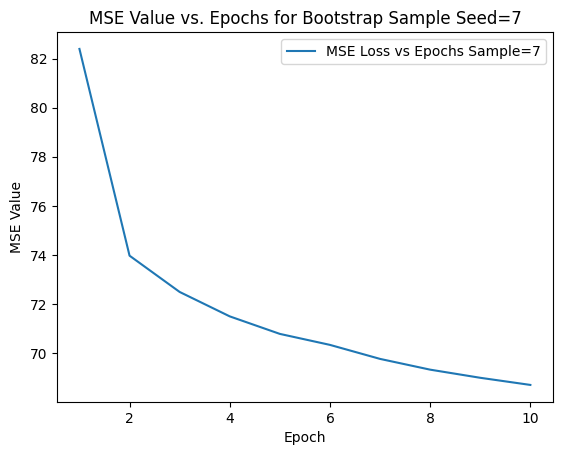

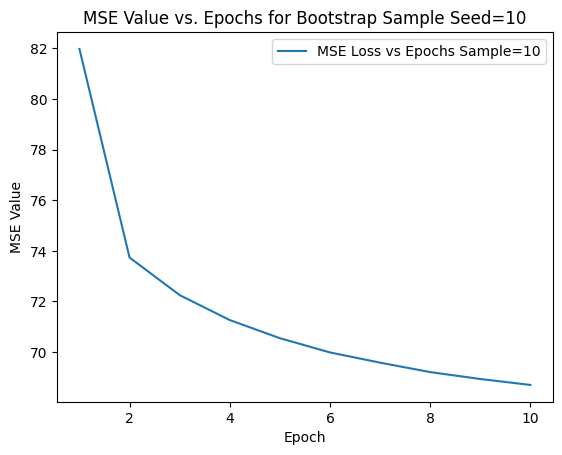

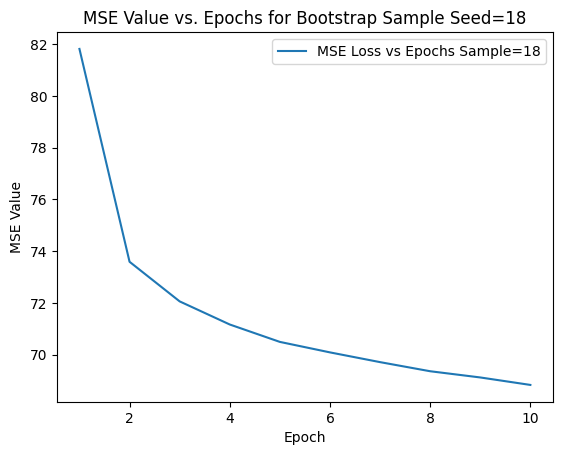

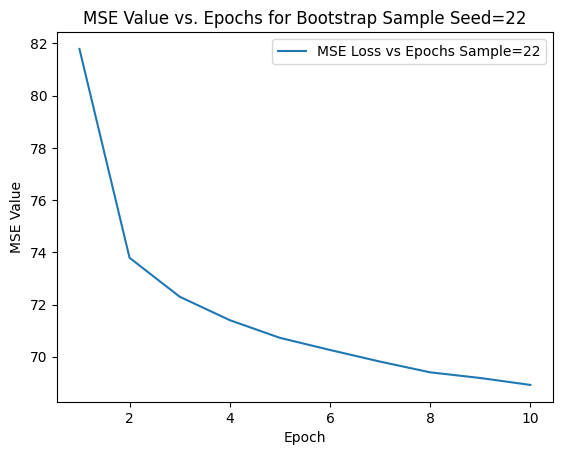

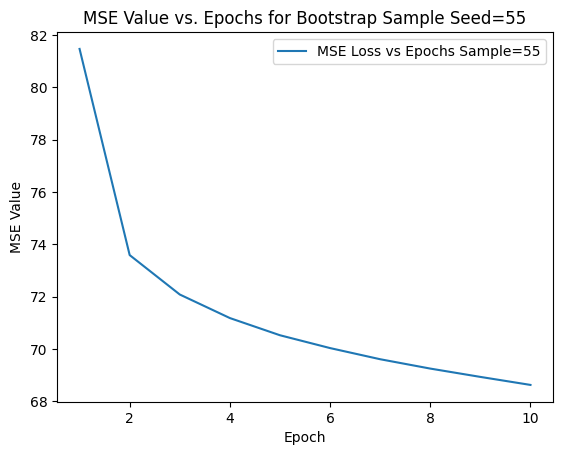

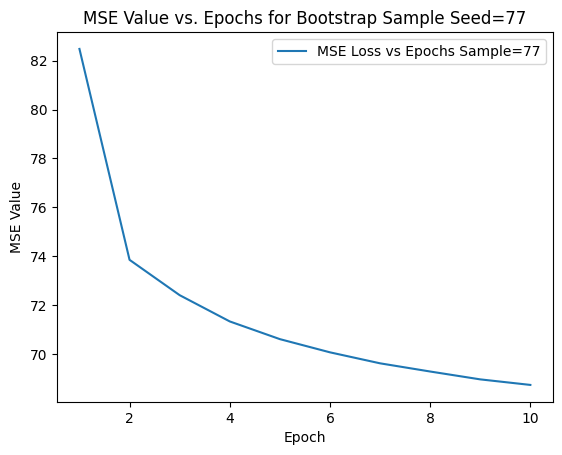

In [8]:
num_lists = len(mse_val1)  # Number of lists
epochs_vae = range(1, 11)  # Epochs (assuming 10 epochs)


# Plot each list in mse_val1
for i, j in zip(range(num_lists), list([7,10,18,22,55,77])):         
    plt.plot(epochs_vae, mse_val1[i], label=f'MSE Loss vs Epochs Sample={j}')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Value')
    plt.title(f'MSE Value vs. Epochs for Bootstrap Sample Seed={j}')
    plot_path = '/home/nitesh/Documents/MY_THESIS/MAMI/Plots/'
    plt.savefig(plot_path + f'6_VAE_TrainingLoss_Epoch_Plot_perturb_aug{j}.png')
    plt.legend()
    plt.show()
    plt.close()  # Close the connection 

# # Save the plots in the local directory
# for i in range(num_lists):
#     plt.savefig(f'plot_{i}.png')
#     plt.close()  # Cl

## SAVE MSE ERROR RESULTS CORRESPONDING TO VAE TRAINING 

In [9]:

# csv_file ='/home/nitesh/Documents/MY_THESIS/MAMI/Plots/VAE_MSE_VALUES'
# Write mse_val1 to CSV file
df = pd.DataFrame(mse_val1)

# Save the DataFrame to a CSV file
# df.to_csv(csv_file, index=False)

# Define the CSV file path
csv_file = '/home/nitesh/Documents/MY_THESIS/MAMI/Plots/6_VAE_training_loss_epochs_BLIPPERTURB.csv'

df.to_csv(csv_file, index=False)


## SAVE THE CLASSIFICATION REPORT ERROR TO LOCAL 

In [11]:
df_BLPCLPXGB.to_excel('6_classification_report_DistilBERT_ViT_VAE_BLIP_XGBOOST_BLIPPERTURB.xlsx', index=False)

https://xgboost.readthedocs.io/en/stable/parameter.html

refer aboev document for classification error and  logloss error